Graphs to make:
- [ ] 1. Conversion vs peak-to-peak voltage
- [ ] 2. Conversion vs displaced charge
- [ ] 3. Conversion vs microdischarge number
- [ ] 4. Conversion vs rms reactor current
- [ ] 5. H₂/CO ratio vs peak-to-peak voltage
- [ ] 6. H₂/CO ratio vs displaced charge
- [ ] 7. H₂/CO ratio vs microdischarge number
- [ ] 8. H₂/CO ratio vs rms reactor current
- [ ] 9. H₂/CO ratio vs conversion
- [ ] 10. C-selectivity vs peak-to-peak voltage
- [ ] 11. C-selectivity vs displaced charge
- [ ] 12. C-selectivity vs microdischarge number
- [ ] 13. C-selectivity vs rms reactor current
- [ ] 14. C-yield vs peak-to-peak voltage
- [ ] 15. C-yield vs displaced charge
- [ ] 16. C-yield vs microdischarge number
- [ ] 17. C-yield vs rms reactor current
- [ ] 18. H-selectivity vs peak-to-peak voltage
- [ ] 19. H-selectivity vs displaced charge
- [ ] 20. H-selectivity vs microdischarge number
- [ ] 21. H-selectivity vs rms reactor current
- [ ] 22. H-yield vs peak-to-peak voltage
- [ ] 23. H-yield vs displaced charge
- [ ] 24. H-yield vs microdischarge number
- [ ] 25. H-yield vs rms reactor current

Step 0: libraries & static variables

In [1]:
# Importing the libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Define the alpha value for the post-plasma materials
alpha = 0.65

# Define the color for each material
cb_colors = {
    'γ-Al₂O₃': (0/255, 0/255, 0/255),
    '2% CuO@γ-Al₂O₃': (86/255, 180/255, 233/255),
    '10% CuO@γ-Al₂O₃': (0/255, 114/255, 178/255),
    '2% Fe₂O₃@γ-Al₂O₃': (230/255, 159/255, 0/255),
    '10% Fe₂O₃@γ-Al₂O₃': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
material_order = [
    'γ-Al₂O₃',
    '2% CuO@γ-Al₂O₃',
    '2% Fe₂O₃@γ-Al₂O₃',
    '10% CuO@γ-Al₂O₃',
    '10% Fe₂O₃@γ-Al₂O₃'
]

t_quantile = stats.t.ppf(1 - 0.05/2, 7)

In [3]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

Step 1: Import the data

In [4]:
# set the folder
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\drm\ugent'

In [5]:
# set the reaction data file name and path
file_path_reaction = os.path.join(
    folder_path,
    'ugent_drm_reaction_data_combined.parquet'
)

# read the reaction data file
df_reaction = pd.read_parquet(file_path_reaction)

In [6]:
# set the electrical data file name and path
file_path_electrical = os.path.join(
    folder_path,
    'ugent_drm_electrical_data_combined.parquet'
)

# read the electrical data file
df_electrical = pd.read_parquet(file_path_electrical)

Step 2: Preprocess the data

In [7]:
# Preparing the reaction data

# Subset the data by selecting the rows in which res_time_sec
# is between 10 and 70 (inclusive)
df_reaction = df_reaction[
    (df_reaction['res_time_sec'] >= 10) &
    (df_reaction['res_time_sec'] <= 80)
].reset_index(drop=True)

# Substitue the values in the column 'material' with custom values
df_reaction['material'] = df_reaction['material'].map(
    {
        'SASOL 1.8': 'γ-Al₂O₃',
        '2% Cu(II)(NO3)2 @ SASOL 1.8': '2% CuO@γ-Al₂O₃',
        '10% Cu(II)(NO3)2 @ SASOL 1.8': '10% CuO@γ-Al₂O₃',
        '2% Fe(III)Citrate @ SASOL 1.8': '2% Fe₂O₃@γ-Al₂O₃',
        '10% Fe(III)Citrate @ SASOL 1.8': '10% Fe₂O₃@γ-Al₂O₃'
    }
)

# rename some columns in the df_reaction dataframe
df_reaction.rename(
    columns={
        'material': 'material_name',
        'res_time_sec': 'residence_time_s'
    },
    inplace=True
)

In [8]:
# Preparing the electrical data

# subset the data
df_electrical = df_electrical[
    (df_electrical['residence_time_s'] >= 10) &
    (df_electrical['residence_time_s'] <= 80) &
    (df_electrical['plasma_state'] == 'plasma')
].reset_index(drop=True)

df_electrical['material_name'] = df_electrical['material_name'].map(
    {
        'sasol-1.8-c450': 'γ-Al₂O₃',
        'sasol-1.8-cuo-02%': '2% CuO@γ-Al₂O₃',
        'sasol-1.8-cuo-10%': '10% CuO@γ-Al₂O₃',
        'sasol-1.8-fe2o3-02%': '2% Fe₂O₃@γ-Al₂O₃',
        'sasol-1.8-fe2o3-10%': '10% Fe₂O₃@γ-Al₂O₃'
    }
)

df_electrical = df_electrical[
    df_electrical.groupby(['material_name', 'residence_time_s'])['measurement_number'].transform("max") == df_electrical['measurement_number']
].drop(columns=["measurement_number"]).reset_index(drop=True)

Step 3: Merge the data

In [9]:
# merge the reaction and electrical dataframes
df_combined = pd.merge(
    df_reaction,
    df_electrical,
    on=['material_name', 'residence_time_s']
).assign(
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4687)*(17.31/x['residence_time_s']))*24.055,
        ndigits=-1
    ).astype(int),
    compound=lambda x: x['compound'].map(
        {
            'CO2': 'CO₂',
            'H2': 'H₂',
            'CO': 'CO',
            'O2': 'O₂',
            'CH4': 'CH₄',
            'C2H6': 'C₂H₆',
            'C2H4': 'C₂H₄',
            'C2H2': 'C₂H₂',
            'C3H8': 'C₃H₈',
            'CH3OH': 'CH₃OH',
            'C2H5OH': 'C₂H₅OH',
            'CH3OCH3': 'CH₃OCH₃',
            'Total' : 'Total'
        }
    )
).reset_index(drop=True)

In [10]:
print(df_combined.columns)

Index(['material_name', 'residence_time_s', 'compound', 'flow_mlmin', 'alpha',
       'conc_avg_corr', 'conc_avg_corr_sd', 'conv', 'conv_sd', 'selec_c',
       'selec_c_sd', 'yield_c', 'yield_c_sd', 'selec_o', 'selec_o_sd',
       'yield_o', 'yield_o_sd', 'selec_h', 'selec_h_sd', 'yield_h',
       'yield_h_sd', 'yield_ratio', 'yield_ratio_sd', 'balance_c',
       'balance_c_sd', 'balance_o', 'balance_o_sd', 'balance_h',
       'balance_h_sd', 'plasma_power_watt_avg', 'plasma_power_watt_sd',
       'sei_kjmol', 'sei_kjmol_sd', 'plasma_temp_celc', 'ee_gf_perc',
       'ee_gf_perc_sd', 'ee_lhv_perc', 'ee_lhv_perc_sd', 'ee_hhv_perc',
       'ee_hhv_perc_sd', 'measurement_number', 'project_name',
       'psdata_file_name', 'measurement_date', 'material_supplier',
       'reaction_type', 'wattage_const', 'plasma_state', 'cycle',
       'power_plasma_W', 'power_plasma_UIprod_W', 'power_source_W', 'U_pp_V',
       'current_rms_reactor_A', 'current_rms_plasma_A', 'current_rms_source_A',
       

Step 4: Conv vs. electrical

Step 4.1: Conv vs. U_pp

In [11]:
# Subset the data
df_conv = df_combined[
    [
        'material_name',
        'residence_time_s',
        'compound',
        'sei_kjmol',
        'sei_kjmol_sd',
        'sei_ideal_kjmol',
        'conv',
        'conv_sd',
        'U_pp_V',
        'U_burning_avg_V',
        'U_breakdown_avg_V',
        'Q_delta_dis_avg_C',
        'avg_num_udisch_per_cycle',
        'current_rms_plasma_A',
        'current_rms_reactor_A',
        'yield_ratio',
        'yield_ratio_sd',
        'C_cell_avg_F',
        'C_diel_eff_avg_F',
        'alpha_avg',
        'beta_avg'
    ]
].query(
    "compound in ['CO₂', 'CH₄', 'Total']"
).drop_duplicates(
).assign(
    conv=lambda x: x['conv'] * 100,
    conv_sd=lambda x: x['conv_sd'] * 100,
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    U_burning_avg_kV=lambda x: x['U_burning_avg_V'] / 1000,
    U_breakdown_avg_kV=lambda x: x['U_breakdown_avg_V'] / 1000,
    Q_delta_dis_avg_nC=lambda x: x['Q_delta_dis_avg_C'] * 1e9,
    current_rms_plasma_mA=lambda x: x['current_rms_plasma_A'] * 1e3,
    current_rms_reactor_mA=lambda x: x['current_rms_reactor_A'] * 1e3,
    C_cell_avg_pF=lambda x: x['C_cell_avg_F'] * 1e12,
    C_diel_eff_avg_pF=lambda x: x['C_diel_eff_avg_F'] * 1e12
).reset_index(
    drop=True
).sort_values(
    by=['residence_time_s', 'compound', 'material_name']
).copy()

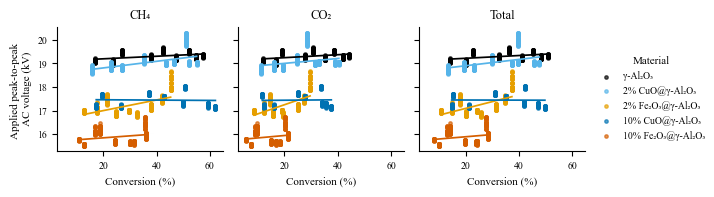

In [12]:
g = sns.lmplot(
    x='conv',
    y='U_pp_kV',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", size=8)

plt.savefig(
    r"C:\Users\sande\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_pp_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_U_pp_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.2: Conv vs. displ charge

In [ ]:
g = sns.lmplot(
    x='conv',
    y='Q_delta_dis_avg_nC',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Displaced charge \n per discharge (nC)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_displ_Q_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_displ_Q_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.3: Conv vs. # µ-disch

In [ ]:
g = sns.lmplot(
    x='conv',
    y='avg_num_udisch_per_cycle',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Average # of µ-discharges \n per cycle (indicative)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_num_udisch_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per cycle (indicative)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_num_udisch_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.4: Conv vs. RMS reactor current

In [ ]:
g = sns.lmplot(
    x='conv',
    y='current_rms_reactor_mA',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("RMS reactor current (mA)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_rms_reactor_I_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'current_rms_reactor_mA',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='current_rms_reactor_mA',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_rms_reactor_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.4.5: Conv vs. RMS plasma current

In [ ]:
g = sns.lmplot(
    x='conv',
    y='current_rms_plasma_mA',
    hue='material_name',
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("RMS plasma current (mA)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_rms_plasma_I_vs_conv.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'current_rms_plasma_mA',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='current_rms_plasma_mA',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="RMS plasma current (mA)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_rms_plasma_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.5: Conv vs C_cell_avg_F

In [ ]:
g = sns.lmplot(
    x='conv',
    y='C_cell_avg_pF',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Avg cell capacitance (pF)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_C_cell_avg_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'C_cell_avg_pF',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='C_cell_avg_pF',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Avg cell capacitance (pF)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_C_cell_avg_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'C_cell_avg_pF',
    'U_pp_kV',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='C_cell_avg_pF',
        y='U_pp_kV',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Avg cell capacitance (pF)",
    y_var="Applied peak-to-peak \n AC voltage (kV)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_pp_vs_C_cell_avg_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.6: Conv vs C_diel_eff_avg_pF

In [ ]:
df_conv['C_diel_eff_avg_norm'] = (
    df_conv['C_diel_eff_avg_pF'] / df_conv['C_cell_avg_pF']
)
g = sns.lmplot(
    x='conv',
    y='C_diel_eff_avg_norm',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("Normalized effective\ndielectric capacitance (pF)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_C_diel_eff_avg_norm_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'C_diel_eff_avg_norm',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='C_diel_eff_avg_norm',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Normalized effective\ndielectric capacitance (pF)",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_C_diel_eff_avg_norm_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.7: Conv vs U_burning_avg

In [ ]:
g = sns.lmplot(
    x='conv',
    y='U_burning_avg_kV',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("U_burning_avg_kV", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_burning_avg_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_burning_avg_kV',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_burning_avg_kV',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="U_burning_avg_kV",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_U_burning_avg_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.8: Conv vs U_breakdown_avg

In [ ]:
g = sns.lmplot(
    x='conv',
    y='U_breakdown_avg_kV',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("U_breakdown_avg_kV", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_breakdown_avg_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'U_breakdown_avg_kV',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_breakdown_avg_kV',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="U_breakdown_avg_kV",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_U_breakdown_avg_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 4.9: Conv vs beta_avg

In [ ]:
g = sns.lmplot(
    x='conv',
    y='beta_avg',
    hue='material_name',
    hue_order=material_order,
    col='compound',
    data=df_conv,
    col_wrap=3,
    palette=cb_colors,
    height=5/2.54,
    aspect=1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("Conversion (%)", size=8)
g.set_ylabels("beta_avg", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_beta_avg_vs_conv_per_comp.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'beta_avg',
    'conv',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='beta_avg',
        y='conv',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(col_template="{col_name}", row_template="{row_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="beta_avg",
    y_var="Conversion (%)",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_conv_vs_beta_avg_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 5: H₂/CO ratio vs. electrical

Step 5.1: H₂/CO ratio vs. U_pp

In [ ]:
g = sns.lmplot(
    x='yield_ratio',
    y='U_pp_kV',
    hue='material_name',
    data=df_conv,
    palette=cb_colors,
    height=5/2.54,
    aspect=1.1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("H₂/CO yield ratio", size=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_U_pp_vs_ratio.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=4/2.54,
    aspect=1
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'yield_ratio',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='yield_ratio',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material", prop={'size': 8})
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="H₂/CO yield ratio",
    size=8
)

sns.move_legend(
    g,
    loc='lower right',
    bbox_to_anchor=(0.78, 0.08),
    frameon=False,
    fontsize=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_ratio_vs_U_pp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 5.2: H₂/CO ratio vs. displ charge

In [ ]:
g = sns.lmplot(
    x='yield_ratio',
    y='Q_delta_dis_avg_nC',
    hue='material_name',
    data=df_conv,
    palette=cb_colors,
    height=5/2.54,
    aspect=1.1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("H₂/CO yield ratio", size=8)
g.set_ylabels("Displaced charge \n per discharge (nC)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_displ_Q_vs_ratio.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=4/2.54,
    aspect=1
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'yield_ratio',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='yield_ratio',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material", prop={'size': 8})
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="H₂/CO yield ratio",
    size=8
)

sns.move_legend(
    g,
    loc='lower right',
    bbox_to_anchor=(0.78, 0.08),
    frameon=False,
    fontsize=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_ratio_vs_displ_Q_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 5.3: H₂/CO ratio vs. # µ-disch

In [ ]:
g = sns.lmplot(
    x='yield_ratio',
    y='avg_num_udisch_per_cycle',
    hue='material_name',
    data=df_conv,
    palette=cb_colors,
    height=5/2.54,
    aspect=1.1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("H₂/CO yield ratio", size=8)
g.set_ylabels("Average # of µ-discharges \n per discharge (indicative)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_num_udisch_vs_ratio.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=4/2.54,
    aspect=1
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'yield_ratio',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='yield_ratio',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material", prop={'size': 8})
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="H₂/CO yield ratio",
    size=8
)

sns.move_legend(
    g,
    loc='lower right',
    bbox_to_anchor=(0.78, 0.08),
    frameon=False,
    fontsize=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_ratio_vs_num_udisch_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 5.4: H₂/CO ratio vs. RMS reactor current

In [ ]:
# Create a new column for the scaled y-values
df_conv['current_rms_reactor_mA'] = df_conv['current_rms_reactor_A'] * 1000

# Plot using the new column
g = sns.lmplot(
    x='yield_ratio',
    y='current_rms_reactor_mA',
    hue='material_name',
    data=df_conv,
    palette=cb_colors,
    height=5/2.54,
    aspect=1.1,
    scatter_kws={'s': 6, 'alpha': alpha},
    line_kws={'lw': 1.25},
    ci=None
)

g.legend.set_title("Material", prop={'size': 8})
g.set_titles(col_template="{col_name}", size=9)
g.set_xlabels("H₂/CO yield ratio", size=8)
g.set_ylabels("RMS reactor current (mA)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_rms_reactor_I_vs_ratio.pdf",
    bbox_inches='tight'
)
plt.show()

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='sei_ideal_kjmol',
    col_wrap=3,
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=4/2.54,
    aspect=1
)

g.map(
    sns.scatterplot,
    'current_rms_reactor_mA',
    'yield_ratio',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='current_rms_reactor_mA',
        y='yield_ratio',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material", prop={'size': 8})
g.set_titles(col_template="{col_name} kJ mol⁻¹", size=9)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="H₂/CO yield ratio",
    size=8
)

sns.move_legend(
    g,
    loc='lower right',
    bbox_to_anchor=(0.78, 0.08),
    frameon=False,
    fontsize=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_ratio_vs_rms_reactor_I_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 6: H₂/CO ratio vs. Conv

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_conv,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=3/2.54,
    aspect=1.25
)

g.map(
    sns.scatterplot,
    'conv',
    'yield_ratio',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_conv.groupby(['compound', 'sei_ideal_kjmol'], sort=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='conv',
        y='yield_ratio',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=9
)
g.set_axis_labels(
    x_var="Conversion (%)",
    y_var="H₂/CO yield ratio",
    size=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_ratio_vs_conv_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7: C-selectivity & -yield vs electrical

In [ ]:
# Subset the data
df_selec_yield_c = df_combined[
    [
        'material_name',
        'compound',
        'residence_time_s',
        'sei_kjmol',
        'sei_kjmol_sd',
        'sei_ideal_kjmol',
        'selec_c',
        'selec_c_sd',
        'yield_c',
        'yield_c_sd',
        'U_pp_V',
        'Q_delta_dis_avg_C',
        'avg_num_udisch_per_cycle',
        'current_rms_reactor_A'
    ]
].query(
    "compound in ['CO', 'C₂H₆', 'C₂H₄', 'C₂H₂', 'C₃H₈', 'CH₃OCH₃', 'CH₃OH', 'C₂H₅OH']"
).drop_duplicates(
).assign(
    selec_c=lambda x: x['selec_c'] * 100,
    selec_c_sd=lambda x: x['selec_c_sd'] * 100,
    yield_c=lambda x: x['yield_c'] * 100,
    yield_c_sd=lambda x: x['yield_c_sd'] * 100,
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    Q_delta_dis_avg_nC=lambda x: x['Q_delta_dis_avg_C'] * 1e9,
    plasma_rms_current_mA=lambda x: x['current_rms_reactor_A'] * 1e3
).reset_index(
    drop=True
).copy()

# Define the custom order for 'compound'
compound_order = ['CO', 'C₂H₆', 'C₂H₄', 'C₂H₂', 'C₃H₈', 'CH₃OCH₃', 'CH₃OH', 'C₂H₅OH']

# Convert 'compound' column to a categorical type with the specified order
df_selec_yield_c['compound'] = pd.Categorical(df_selec_yield_c['compound'], categories=compound_order, ordered=True)

# Now sort by 'sei_ideal_kjmol', 'compound' (in the custom order), and 'material_name'
df_selec_yield_c = df_selec_yield_c.sort_values(
    by=['sei_ideal_kjmol', 'compound', 'material_name']
).reset_index(drop=True)

Step 7.1: selec_c vs. U_pp

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'selec_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='selec_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="Carbon \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_c_vs_U_pp_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.2: yield_c vs. U_pp

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'yield_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='yield_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="Carbon \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_c_vs_U_pp_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.3: selec_c vs. displ charge

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'selec_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='selec_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="Carbon \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_c_vs_displ_Q_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.4: yield_c vs. displ charge

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'yield_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='yield_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="Carbon \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_c_vs_displ_Q_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.5: selec_c vs. # µ-disch

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'selec_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='selec_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="Carbon \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_c_vs_num_udisch_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.6: yield_c vs. # µ-disch

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'yield_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='yield_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="Carbon \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_c_vs_num_udisch_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.7: selec_c vs. RMS reactor current

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'plasma_rms_current_mA',
    'selec_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='plasma_rms_current_mA',
        y='selec_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="Carbon \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_c_vs_rms_reactor_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 7.8: yield_c vs. RMS reactor current

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_c,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'plasma_rms_current_mA',
    'yield_c',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_c.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='plasma_rms_current_mA',
        y='yield_c',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="Carbon \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_c_vs_rms_reactor_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8: H-selectivity & -yield vs electrical

In [ ]:
# Subset the data
df_selec_yield_h = df_combined[
    [
        'material_name',
        'compound',
        'residence_time_s',
        'sei_kjmol',
        'sei_kjmol_sd',
        'sei_ideal_kjmol',
        'selec_h',
        'selec_h_sd',
        'yield_h',
        'yield_h_sd',
        'U_pp_V',
        'Q_delta_dis_avg_C',
        'avg_num_udisch_per_cycle',
        'current_rms_reactor_A'
    ]
].query(
    "compound in ['H₂', 'C₂H₆', 'C₂H₄', 'C₂H₂', 'C₃H₈', 'CH₃OCH₃', 'CH₃OH', 'C₂H₅OH']"
).drop_duplicates(
).assign(
    selec_h=lambda x: x['selec_h'] * 100,
    selec_h_sd=lambda x: x['selec_h_sd'] * 100,
    yield_h=lambda x: x['yield_h'] * 100,
    yield_h_sd=lambda x: x['yield_h_sd'] * 100,
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    Q_delta_dis_avg_nC=lambda x: x['Q_delta_dis_avg_C'] * 1e9,
    current_rms_reactor_mA=lambda x: x['current_rms_reactor_A'] * 1e3
).reset_index(
    drop=True
).copy()

# Define the custom order for 'compound'
compound_order = ['H₂', 'C₂H₆', 'C₂H₄', 'C₂H₂', 'C₃H₈', 'CH₃OCH₃', 'CH₃OH', 'C₂H₅OH']

# Convert 'compound' column to a categorical type with the specified order
df_selec_yield_h['compound'] = pd.Categorical(df_selec_yield_h['compound'], categories=compound_order, ordered=True)

# Now sort by 'sei_ideal_kjmol', 'compound' (in the custom order), and 'material_name'
df_selec_yield_h = df_selec_yield_h.sort_values(
    by=['sei_ideal_kjmol', 'compound', 'material_name']
).reset_index(drop=True)

Step 8.1: selec_h vs. U_pp

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'selec_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='selec_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="Hydrogen \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_h_vs_U_pp_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.2: yield_h vs. U_pp

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'U_pp_kV',
    'yield_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='U_pp_kV',
        y='yield_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Applied peak-to-peak \n AC voltage (kV)",
    y_var="Hydrogen \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_h_vs_U_pp_per_comp_per_sei.pdf", 
    bbox_inches='tight'
)
plt.show()

Step 8.3: selec_h vs. displ charge

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'selec_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='selec_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="Hydrogen \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_h_vs_displ_Q_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.4: yield_h vs. displ charge

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'Q_delta_dis_avg_nC',
    'yield_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='Q_delta_dis_avg_nC',
        y='yield_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Displaced charge \n per discharge (nC)",
    y_var="Hydrogen \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_h_vs_displ_Q_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.5: selec_h vs. # µ-disch

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'selec_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='selec_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="Hydrogen \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_h_vs_num_udisch_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.6: yield_h vs. # µ-disch

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'avg_num_udisch_per_cycle',
    'yield_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='avg_num_udisch_per_cycle',
        y='yield_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="Average # of µ-discharges \n per discharge (indicative)",
    y_var="Hydrogen \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_h_vs_num_udisch_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.7: selec_h vs. RMS reactor current

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'current_rms_reactor_mA',
    'selec_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='current_rms_reactor_mA',
        y='selec_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="Hydrogen \n selectivity (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_selec_h_vs_rms_reactor_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 8.8: yield_h vs. RMS reactor current

In [ ]:
# Create a FacetGrid for scatter plots
g = sns.FacetGrid(
    data=df_selec_yield_h,
    col='compound',
    row='sei_ideal_kjmol',
    hue='material_name',
    hue_order=material_order,
    palette=cb_colors,
    height=2/2.54,
    aspect=1.4,
    sharey=False
)

g.map(
    sns.scatterplot,
    'current_rms_reactor_mA',
    'yield_h',
)

# Iterate over each subplot to apply regplot for each group
for ax, (group_keys, subset) in zip(g.axes.flat, df_selec_yield_h.groupby(['sei_ideal_kjmol', 'compound'], sort=False, observed=False)):
    # Apply regplot to the current subset and axis
    sns.regplot(
        x='current_rms_reactor_mA',
        y='yield_h',
        data=subset,
        ax=ax,
        scatter=False,
        color='black',
        ci=None,
        line_kws={'lw': 1.2}
    )

# Adjust legend, labels, and titles
g.add_legend(title="Material")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name} kJ mol⁻¹",
    size=7
)
g.set_axis_labels(
    x_var="RMS reactor current (mA)",
    y_var="Hydrogen \n yield (%)",
    size=7
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_incat_envecon_paper_elsevier\figs\sander_yield_h_vs_rms_reactor_I_per_comp_per_sei.pdf",
    bbox_inches='tight'
)
plt.show()